In [1]:
import torch
import torch.nn as nn
import torch.optim as optim

import numpy as np
from collections import OrderedDict
import matplotlib.pylab as plt

device = 'cuda' if torch.cuda.is_available() else 'cpu'
print(device)
print(torch.__version__)

cuda
1.9.0


In [2]:
class DNN(nn.Module):
    def __init__(self, layers):
        super().__init__()

        n_hidden = len(layers) 
        self.activation = nn.Tanh
        layer_list = []

        for i in range(n_hidden-2):

            linear = torch.nn.Linear(layers[i], layers[i+1])

            nn.init.xavier_normal_(linear.weight.data, gain=1.0)
            nn.init.zeros_(linear.bias.data)

            layer_list.append(
                ('layer_%d' % i, linear)
            )
            layer_list.append(
                ('activation_%d' % i, self.activation())
            )
        
        linear = torch.nn.Linear(layers[n_hidden-2], layers[n_hidden-1])
        nn.init.xavier_normal_(linear.weight.data, gain=1.0)
        nn.init.zeros_(linear.bias.data)

        layer_list.append(('layer_%d' % (n_hidden-2), linear))
        
        layerDict = OrderedDict(layer_list)
        self.layers = torch.nn.Sequential(layerDict)

    def forward(self, x):
        out = self.layers(x)
        return out

In [3]:
class PINN_Burgers:
    
    def __init__(self, net, x0, y0, x1, lb, ub, dt, q, device):
        
        # data
        self.x0 = x0; self.x1 = x1; 
        self.lb = torch.tensor(lb).float().to(device)
        self.ub = torch.tensor(ub).float().to(device)
    
        self.y0 = torch.tensor(y0).float().to(device)
        
        # net
        self.net = net.to(device)
        
        # unit time
        self.dt = torch.tensor(dt).to(device)
        # parameters
        tmp = np.float32(np.loadtxt('./Utilities/IRK_weights/Butcher_IRK%d.txt' % (q), ndmin = 2))
        weights =  np.reshape(tmp[0:q**2+q], (q+1,q))

        self.IRK_weights = torch.from_numpy(weights).to(device) # q+1 x q
       
        # opt: using both Adam and LBFGS
        self.opt_LBFGS = optim.LBFGS(
            self.net.parameters(), 
            lr=1., 
            max_iter=50000, 
            max_eval=50000, 
            history_size=50,
            tolerance_grad=1e-5, 
            tolerance_change=1.0 * np.finfo(float).eps,
            line_search_fn="strong_wolfe"       # can be "strong_wolfe"
        )
        self.iter = 0
        self.opt_Adam = optim.Adam(self.net.parameters(), lr=0.003)
        self.q = q
        self.device = device
    def neural_net(self, x):
        x = 2*(x-self.lb)/(self.ub-self.lb) - 1
        u = self.net(x)
        return u
    def create_dummy(self, x):
        return torch.ones((x.shape[0], self.q), requires_grad=True).to(self.device)

    def net_U0(self, x, dummy_x):
        lambda_1 = 1         
        lambda_2 = 0.01/np.pi

        u1 = self.neural_net(x)
        u = u1[:,:-1]

        # very important! u is a matrix (stacked vector), we need jocobian J 

        # for single input x 
        # with x.shape = 1x1, u.shape = 1xq, J.shape = 1xq

        # calculation in torch:
        #  g_u = du/dx @ dummy = J @ dummy with shape 1xq @ qx1 = 1x1
        g_u = torch.autograd.grad(u, x, dummy_x, 
                                    retain_graph=True,
                                    create_graph=True)[0]
        
        # dg_u/ddummy @ torch.ones_like(g_u) = du/dx with shape 1xq

        u_x = torch.autograd.grad(g_u, dummy_x, torch.ones_like(g_u),
                                  retain_graph=True,
                                  create_graph=True)[0]

        # Note that we did bach-level computation: g_u will have shape nx1 (should be nx1x1 logically)
        assert g_u.shape == (x.shape[0],1)
        assert u_x.shape == (x.shape[0], self.q)

        # same here
        g_u_x = torch.autograd.grad(u_x, x, dummy_x,
                                    retain_graph=True,
                                    create_graph=True)[0]

        u_xx = torch.autograd.grad(g_u_x, dummy_x, torch.ones_like(g_u_x),
                                    retain_graph=True,
                                    create_graph=True)[0]
                                    
        assert g_u_x.shape == (x.shape[0],1)
        assert u_xx.shape == (x.shape[0], self.q)

        F = -lambda_1*u*u_x + lambda_2*u_xx
        u0 = u1 - self.dt*(F@self.IRK_weights.T)
        return u0

    def net_U1(self, x):
        u1 = self.neural_net(x)
        return u1

    def _train_step(self):
        
        x0 = torch.tensor(self.x0, requires_grad=True).float().to(device)
        x1 = torch.tensor(self.x1, requires_grad=True).float().to(device)
        
        dummy_x = self.create_dummy(x0)
        u0_pred = self.net_U0(x0, dummy_x)
        u1_pred = self.net_U1(x1)
        loss = torch.sum((self.y0-u0_pred)**2)  + torch.sum(u1_pred**2)

        return loss

    def _closure(self):
        loss = self._train_step()
        self.opt_LBFGS.zero_grad()
        loss.backward()

        self.iter += 1
        if self.iter % 200 == 0:
            print('epoch: {}  loss: {:.4f}'.format(self.iter, loss.item()))
        return loss

    def train(self, epochs):
        self.net.train() # training mode
        for epoch in range(epochs):
            
            loss = self._train_step() 
            
            self.opt_Adam.zero_grad()
            loss.backward()
            self.opt_Adam.step()

            if (epoch+1) % 200 == 0:
                print('epoch: {}  loss: {:.4f}'.format(epoch+1, loss.item()))
        self.opt_LBFGS.step(self._closure)

    def predict(self, x):
        x = torch.tensor(x, requires_grad=True).float().to(device)
        self.net.eval()
        u1_pred = self.net_U1(x)
        return u1_pred.detach().cpu().numpy()


In [4]:
q = 500
layers = [1, 50, 50, 50, q+1]
lb = np.array([-1.0])
ub = np.array([1.0])

N = 250

import scipy.io
data = scipy.io.loadmat('./Data/burgers_shock.mat')

t = data['t'].flatten()[:,None] # T x 1
x = data['x'].flatten()[:,None] # N x 1
Exact = np.real(data['usol']).T # T x N

idx_t0 = 10
idx_t1 = 90
dt = t[idx_t1] - t[idx_t0]

# Initial data
noise_u0 = 0.0
idx_x = np.random.choice(Exact.shape[1], N, replace=False) 
x0 = x[idx_x,:]
u0 = Exact[idx_t0:idx_t0+1,idx_x].T
u0 = u0 + noise_u0*np.std(u0)*np.random.randn(u0.shape[0], u0.shape[1])

# boundary data
x1 = np.vstack((lb,ub))

# Test data
x_star = x

In [5]:
net = DNN(layers)
net

DNN(
  (layers): Sequential(
    (layer_0): Linear(in_features=1, out_features=50, bias=True)
    (activation_0): Tanh()
    (layer_1): Linear(in_features=50, out_features=50, bias=True)
    (activation_1): Tanh()
    (layer_2): Linear(in_features=50, out_features=50, bias=True)
    (activation_2): Tanh()
    (layer_3): Linear(in_features=50, out_features=501, bias=True)
  )
)

In [6]:
pinn = PINN_Burgers(net, x0, u0, x1, lb, ub, dt, q, device)
pinn.train(10000)

epoch: 200  loss: 2093.7227
epoch: 400  loss: 763.0990
epoch: 600  loss: 348.0831
epoch: 800  loss: 120.2327
epoch: 1000  loss: 149.8159
epoch: 1200  loss: 35.8735
epoch: 1400  loss: 26.2159
epoch: 1600  loss: 11.8713
epoch: 1800  loss: 19.7484
epoch: 2000  loss: 134.5613
epoch: 2200  loss: 6.2715
epoch: 2400  loss: 5.5480
epoch: 2600  loss: 5.2327
epoch: 2800  loss: 5.1740
epoch: 3000  loss: 76.6937
epoch: 3200  loss: 4.0096
epoch: 3400  loss: 5.4162
epoch: 3600  loss: 4.3803
epoch: 3800  loss: 3.8642
epoch: 4000  loss: 3.5348
epoch: 4200  loss: 3.2502
epoch: 4400  loss: 3.0423
epoch: 4600  loss: 2.8790
epoch: 4800  loss: 2.7310
epoch: 5000  loss: 2.5784
epoch: 5200  loss: 40.3607
epoch: 5400  loss: 3.2676
epoch: 5600  loss: 2.2347
epoch: 5800  loss: 2.0587
epoch: 6000  loss: 2.7164
epoch: 6200  loss: 3.6346
epoch: 6400  loss: 10.8894
epoch: 6600  loss: 18.0161
epoch: 6800  loss: 2.4067
epoch: 7000  loss: 1.6911
epoch: 7200  loss: 1.6122
epoch: 7400  loss: 1.6491
epoch: 7600  loss: 3.

In [7]:
u1_pred = pinn.predict(x_star)
error = np.linalg.norm(u1_pred[:,-1] - Exact[idx_t1,:], 2)/np.linalg.norm(Exact[idx_t1,:], 2)
print('Error: %e' % (error))

Error: 2.912405e-04


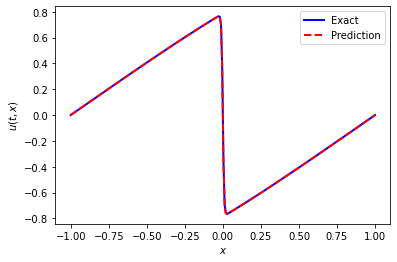

In [8]:
ax = plt.subplot()
ax.plot(x_star, Exact[idx_t1], 'b-', linewidth = 2, label = 'Exact')
ax.plot(x_star, u1_pred[:,-1], 'r--', linewidth = 2, label = 'Prediction')
ax.set_xlabel('$x$')
ax.set_ylabel('$u(t,x)$')
ax.legend(loc='upper right')